In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tqdm import tqdm

# import dataset 1

In [2]:
data1 = pd.read_csv('../1_owid/owid-covid-data.csv')
data1 = data1[data1.continent == 'Europe']

In [3]:
data1 = data1[['iso_code', 'continent', 'location', 'date', 'total_cases',
       'new_cases_smoothed', 'total_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_smoothed_per_million',
       'total_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients_per_million', 
       'hosp_patients_per_million', 
       'weekly_icu_admissions_per_million', 
       'weekly_hosp_admissions_per_million',
       'total_tests_per_thousand','new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 
       'total_vaccinations_per_hundred', 'stringency_index', 'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 
       'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index']]

In [4]:
# replace 'OWID_KOS' with 'KOS'
data1.iso_code = data1.iso_code.str.replace('OWID_KOS', 'KOS')

In [5]:
iso_codes = data1.iso_code.unique()

In [8]:
locations = data1.location.unique()

### create dictionary to convert iso to location back and forth

In [9]:
code_to_location = dict(zip(iso_codes, locations))
location_to_code = dict(zip(locations, iso_codes))

In [10]:
data1.date = pd.to_datetime(data1.date)

In [11]:
data1.set_index('date', inplace=True)

# unstack the data from long to wide form

In [12]:
data1_cases = data1.reset_index().set_index(['date','iso_code']).unstack()

# some function

In [16]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [51]:
def get_results(data=data1_cases, variable='new_cases_smoothed_per_million'):
    """
    returns 
    1. corr matrix in iso,
    2. corr matrix in location,
    3. dictionary of dataframe of time lead lag peak corr
    """
    cross_section_mean = data[variable].mean(axis=1)
    data1_case_demean = data[variable].subtract(cross_section_mean, axis='rows')
    # remove serise with all values missing
    data1_case_demean=data1_case_demean.loc[:,~data1_case_demean.isnull().values.all(axis=0)]
    print('dataframe shape after demean:', data1_case_demean.shape)
    
    # 1. get demean correlation matrix in iso
    data1_case_demean_corr_iso = data1_case_demean.corr() 
    
    # 2. change the matrix from iso labels to location labels
    data1_case_demean_corr_loc = data1_case_demean_corr_iso.copy()
    data1_case_demean_corr_loc.columns = [code_to_location[c] for c in data1_case_demean_corr_iso.columns]
    data1_case_demean_corr_loc.index = [code_to_location[c] for c in data1_case_demean_corr_iso.columns]
    
    # 3. dictionary of dataframe of time lead lag peak corr
    offsets_df_dict={}
    days = 60 # lead lag + & - windows 
    iso_codes = data1_case_demean.columns

    for iso in tqdm(iso_codes):
        d1 = data[variable][iso].dropna()
        offsets_dict = {}

        for c in data1_case_demean_corr_iso.sort_values(iso, ascending=False).index:
            d2 = data.loc[d1.index, variable][c]
            rs = [crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))]
            offset = np.ceil(len(rs)/2-1)-np.argmax(rs)
            offsets_dict[c] = offset
        #     plt.rcParams.update({'figure.max_open_warning': 0}) # do not show warnings
        #     f,ax=plt.subplots(figsize=(14,1))
        #     ax.plot(rs)
        #     ax.axvline(np.ceil(len(rs)/2-1),color='k',linestyle='-',label='Center')
        #     ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
        #     ax.set(title=f'Offset = {offset} days\n{iso} leads <> {c} leads',ylim=[-0,1],xlim=[0,60], xlabel='Offset',ylabel='Pearson r')
        #     ax.set_xticks([0, 30, 60, 91, 121])
        #     ax.set_xticklabels([-60, -30, 0, 30, 60]);
        #     plt.grid()
        #     plt.legend()

        offsets_df_dict[iso] = pd.DataFrame(data={'iso':offsets_dict.keys(), iso:offsets_dict.values()}).set_index('iso')

    return data1_case_demean_corr_iso, data1_case_demean_corr_loc, offsets_df_dict

# get new_cases_smoothed_per_million results from function

In [57]:
cases_corr_iso, cases_corr_loc, cases_offsets_df_dict = get_results(data=data1_cases, variable='new_cases_smoothed_per_million')

  0%|          | 0/46 [00:00<?, ?it/s]

dataframe shape after demean: (347, 46)


100%|██████████| 46/46 [02:22<00:00,  3.09s/it]


## save as CSV files

In [58]:
cases_corr_loc.to_csv('new_cases_smoothed_per_million_demeaned_corr.csv')

## plot heatmap of demeaned corr matrix

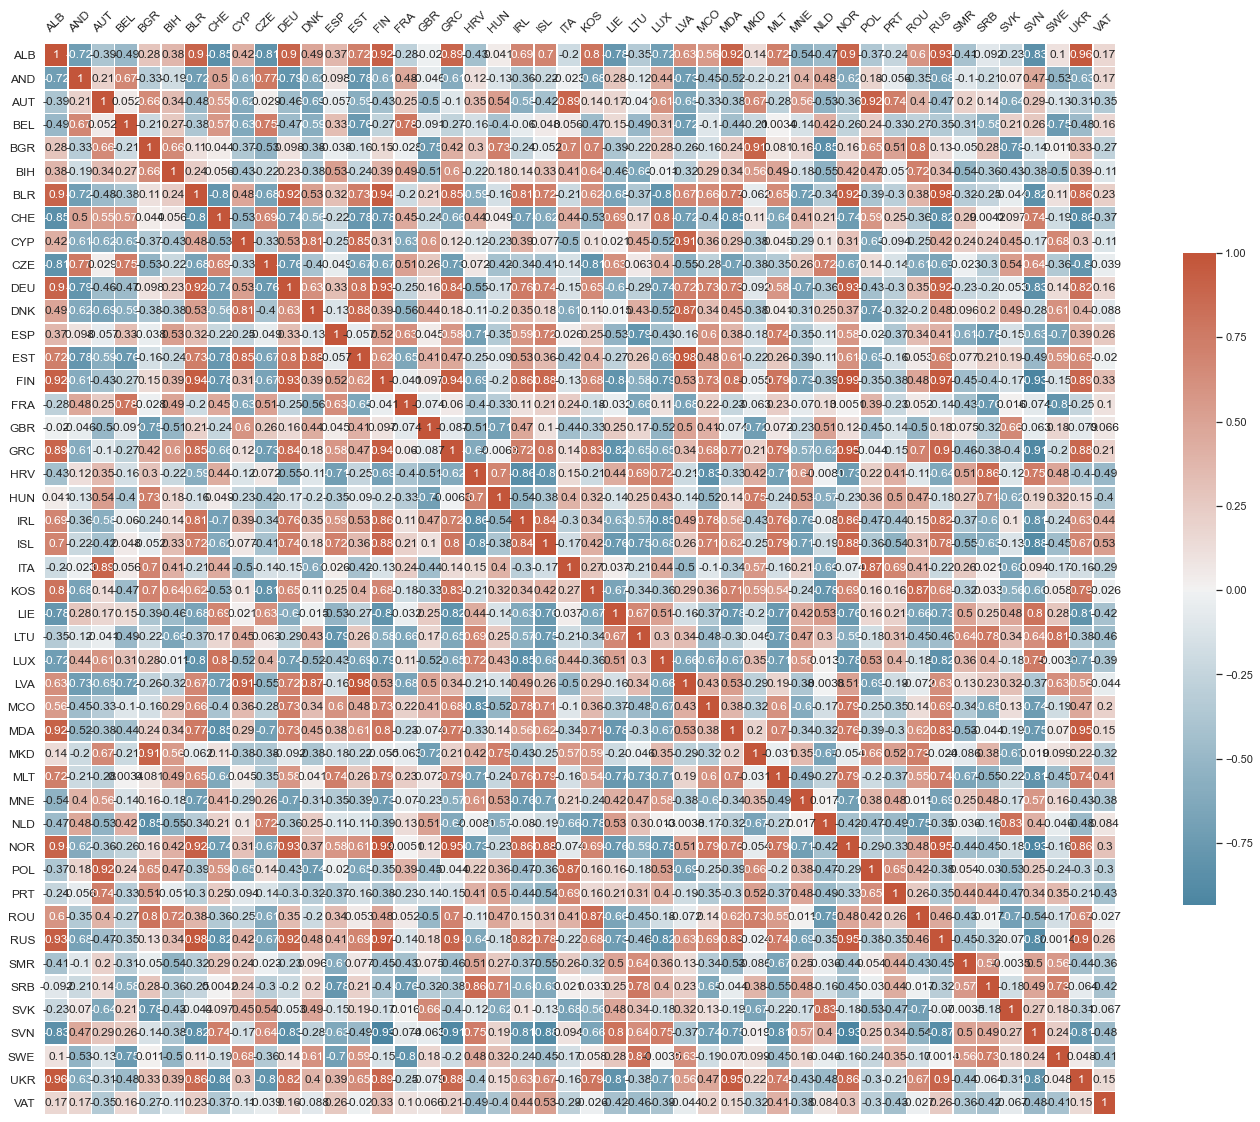

In [59]:
plt.figure(figsize=(24,24))
sns.set_theme(style='white')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
hm = sns.heatmap(cases_corr_iso, square=True, cmap=cmap, center=0,
                annot=True, xticklabels=True, yticklabels=True, 
                cbar_kws={'shrink': 0.5}, cbar=True, linewidths=.5)
hm.set_xticklabels(hm.get_xticklabels(), rotation=45) 
hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
hm.set(xlabel=None, ylabel=None)
hm.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()

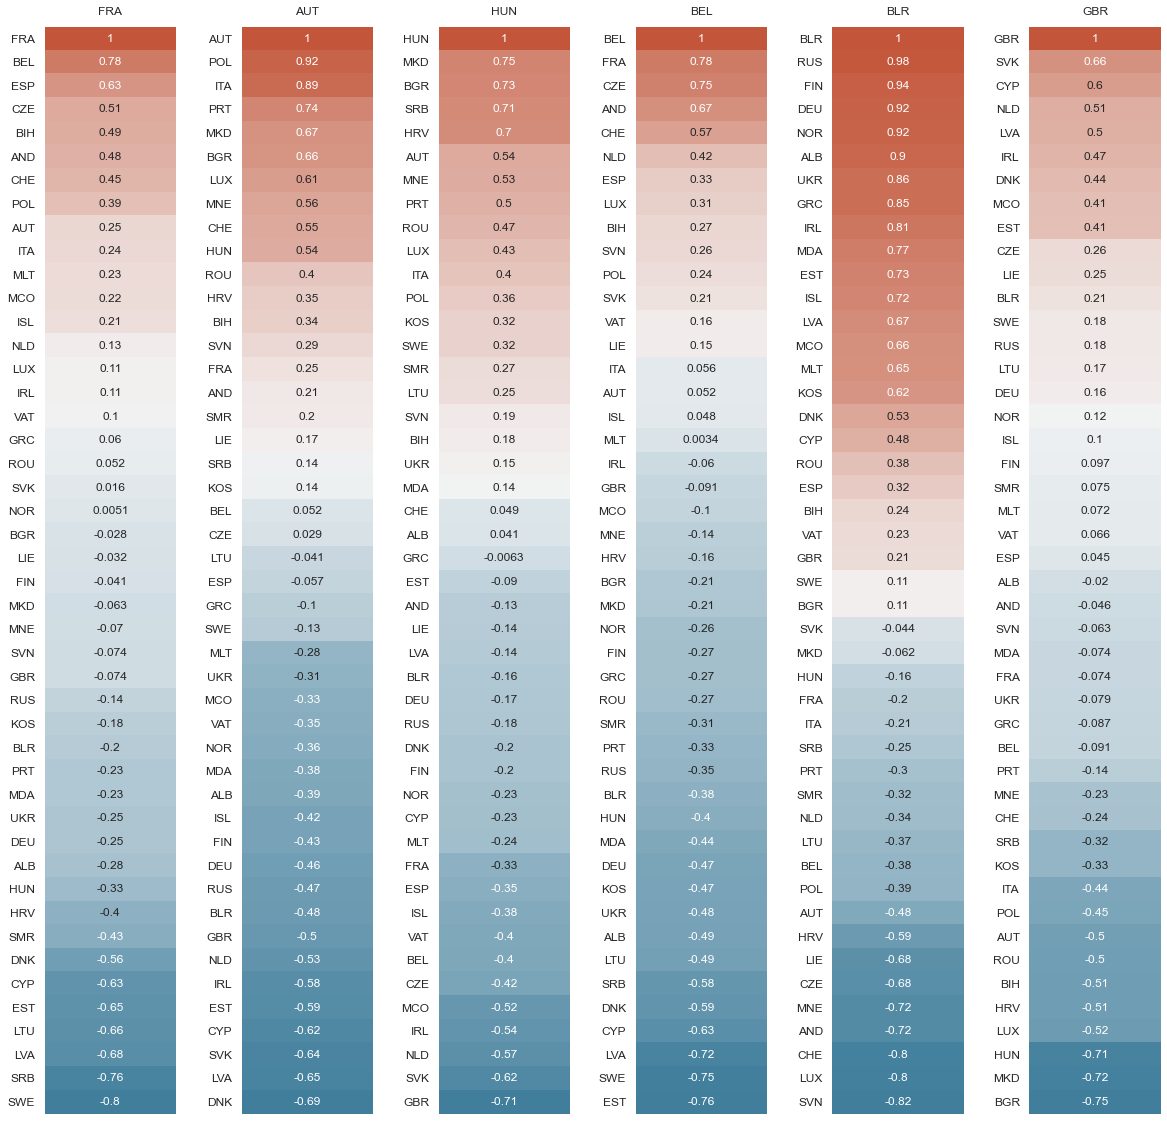

In [60]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.5)
g1=sns.heatmap(cases_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g2=sns.heatmap(cases_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g3=sns.heatmap(cases_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g4=sns.heatmap(cases_corr_iso[['BEL']].sort_values('BEL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g5=sns.heatmap(cases_corr_iso[['BLR']].sort_values('BLR',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g6=sns.heatmap(cases_corr_iso[['GBR']].sort_values('GBR',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)

g1.set(xlabel=None, ylabel=None)
g2.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

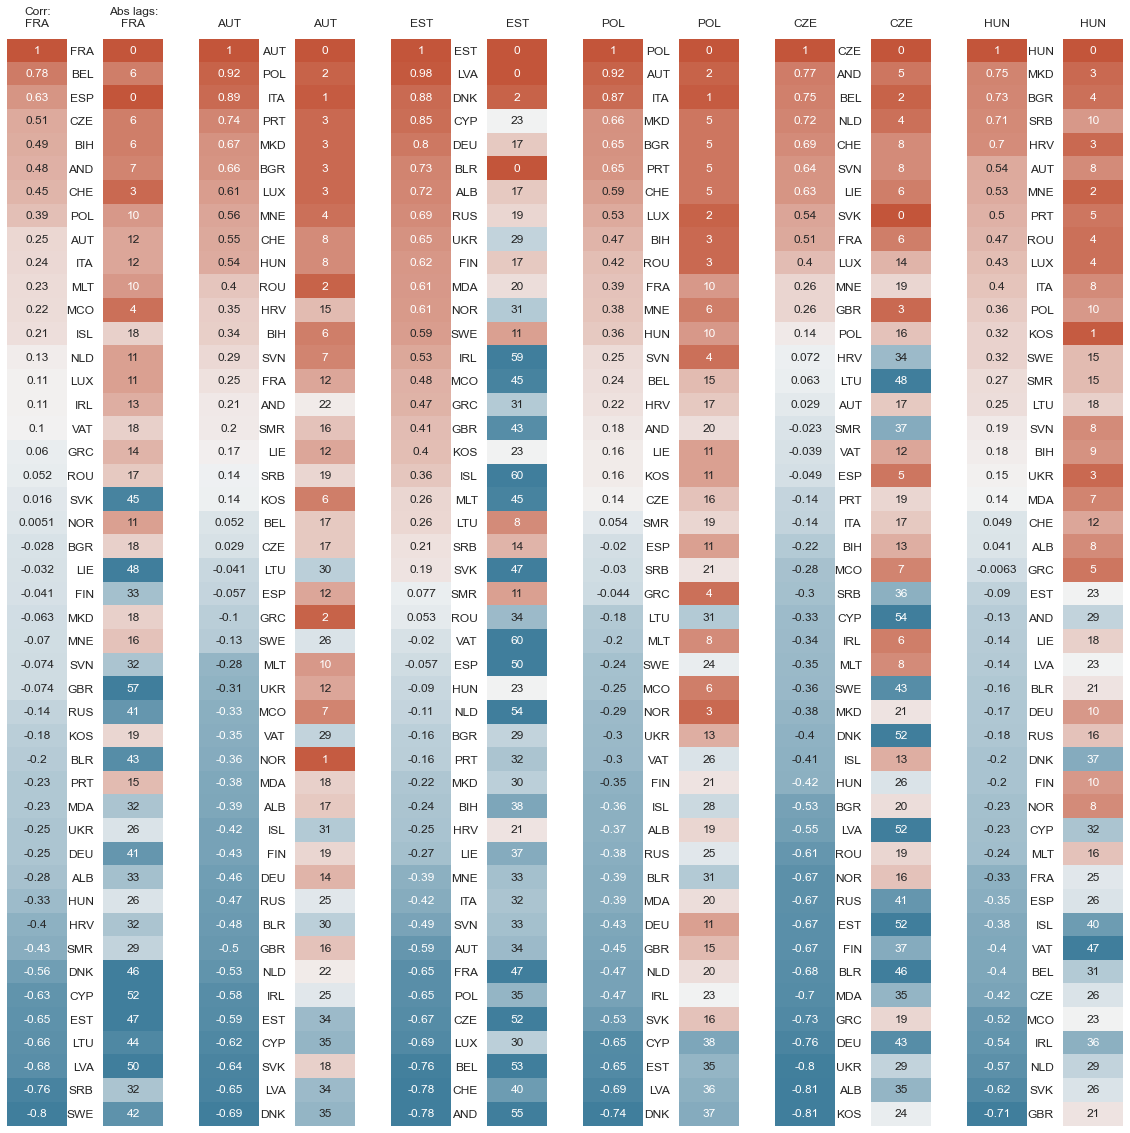

In [294]:
fig, (ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44, ax5, ax55, ax6, ax66) = plt.subplots(1,12, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.6)
cmap2=sns.diverging_palette(20, 230, as_cmap=True)
g1=sns.heatmap(cases_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g11=sns.heatmap(abs(cases_offsets_df_dict['FRA']), annot=True, cmap=cmap2, ax=ax11, vmax=46, vmin=0, center=None, cbar=False)
g2=sns.heatmap(cases_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g22=sns.heatmap(abs(cases_offsets_df_dict['AUT']), annot=True, cmap=cmap2, ax=ax22, vmax=46, vmin=0, center=None, cbar=False)
g3=sns.heatmap(cases_corr_iso[['EST']].sort_values('EST',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g33=sns.heatmap(abs(cases_offsets_df_dict['EST']), annot=True, cmap=cmap2, ax=ax33, vmax=46, vmin=0, center=None, cbar=False)
g4=sns.heatmap(cases_corr_iso[['POL']].sort_values('POL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g44=sns.heatmap(abs(cases_offsets_df_dict['POL']), annot=True, cmap=cmap2, ax=ax44, vmax=46, vmin=0, center=None, cbar=False)
g5=sns.heatmap(cases_corr_iso[['CZE']].sort_values('CZE',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g55=sns.heatmap(abs(cases_offsets_df_dict['CZE']), annot=True, cmap=cmap2, ax=ax55, vmax=46, vmin=0, center=None, cbar=False)
g6=sns.heatmap(cases_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)
g66=sns.heatmap(abs(cases_offsets_df_dict['HUN']), annot=True, cmap=cmap2, ax=ax66, vmax=46, vmin=0, center=None, cbar=False)

g1.set(xlabel='Corr:', ylabel=None)
g1.xaxis.set_label_position('top')
g11.set(xlabel='Abs lags:', ylabel=None)
g11.xaxis.set_label_position('top')
g2.set(xlabel=None, ylabel=None)
g22.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g33.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g44.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g55.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)
g66.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g11.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g22.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g33.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g44.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g55.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g66.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

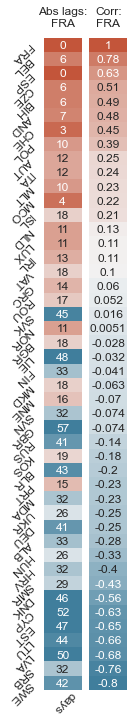

In [307]:
fig, (ax1, ax11) = plt.subplots(1,2, figsize=(1.5,12))
#fig.subplots_adjust(hspace=1)
#fig.subplots_adjust(wspace=1)

cmap2=sns.diverging_palette(20, 230, as_cmap=True)

g1=sns.heatmap(cases_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax11, cmap=cmap, cbar=False)
g11=sns.heatmap(abs(cases_offsets_df_dict['FRA']), annot=True, cmap=cmap2, ax=ax1, vmax=46, vmin=0, center=None, cbar=False)

g1.set_xlabel(xlabel='Corr:', rotation=0)
g1.set_ylabel(ylabel=None)
g1.xaxis.set_label_position('top')
g11.set_xlabel(xlabel='Abs lags:', rotation=0)
g11.set_ylabel(ylabel=None)
g11.xaxis.set_label_position('top')

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g11.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

g1.set_xticklabels(g1.get_xticklabels(), rotation=0)
g11.set_xticklabels(g11.get_xticklabels(), rotation=0)
g11.set_yticklabels(g11.get_yticklabels(), rotation=-45-90)

plt.figtext(0.2, 0.1, 'days', rotation=-45-90)
plt.show()
# paste this horizontally to Word

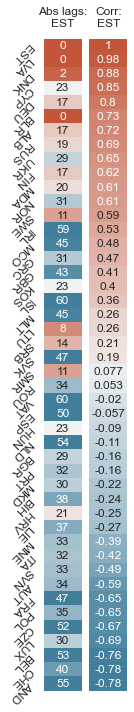

In [297]:
fig, (ax1, ax11) = plt.subplots(1,2, figsize=(1.5,12))
#fig.subplots_adjust(hspace=1)
#fig.subplots_adjust(wspace=1)

cmap2=sns.diverging_palette(20, 230, as_cmap=True)

g1=sns.heatmap(cases_corr_iso[['EST']].sort_values('EST',ascending=False), annot=True, ax=ax11, cmap=cmap, cbar=False)
g11=sns.heatmap(abs(cases_offsets_df_dict['EST']), annot=True, cmap=cmap2, ax=ax1, vmax=46, vmin=0, center=None, cbar=False)

g1.set_xlabel(xlabel='Corr:', rotation=0)
g1.set_ylabel(ylabel=None)
g1.xaxis.set_label_position('top')
g11.set_xlabel(xlabel='Abs lags:', rotation=0)
g11.set_ylabel(ylabel=None)
g11.xaxis.set_label_position('top')

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g11.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

g1.set_xticklabels(g1.get_xticklabels(), rotation=0)
g11.set_xticklabels(g11.get_xticklabels(), rotation=0)
g11.set_yticklabels(g11.get_yticklabels(), rotation=-45-90)

plt.show()
# paste this horizontally to Word

# get new_deaths_smoothed_per_million results from function

In [62]:
deaths_corr_iso, deaths_corr_loc, deaths_offsets_df_dict = get_results(data=data1_cases, 
                                                                       variable='new_deaths_smoothed_per_million')

  0%|          | 0/46 [00:00<?, ?it/s]

dataframe shape after demean: (347, 46)


100%|██████████| 46/46 [02:19<00:00,  3.03s/it]


## save as CSV files

In [63]:
deaths_corr_loc.to_csv('new_deaths_smoothed_per_million_demeaned_corr.csv')

## plot heatmap of demeaned corr matrix

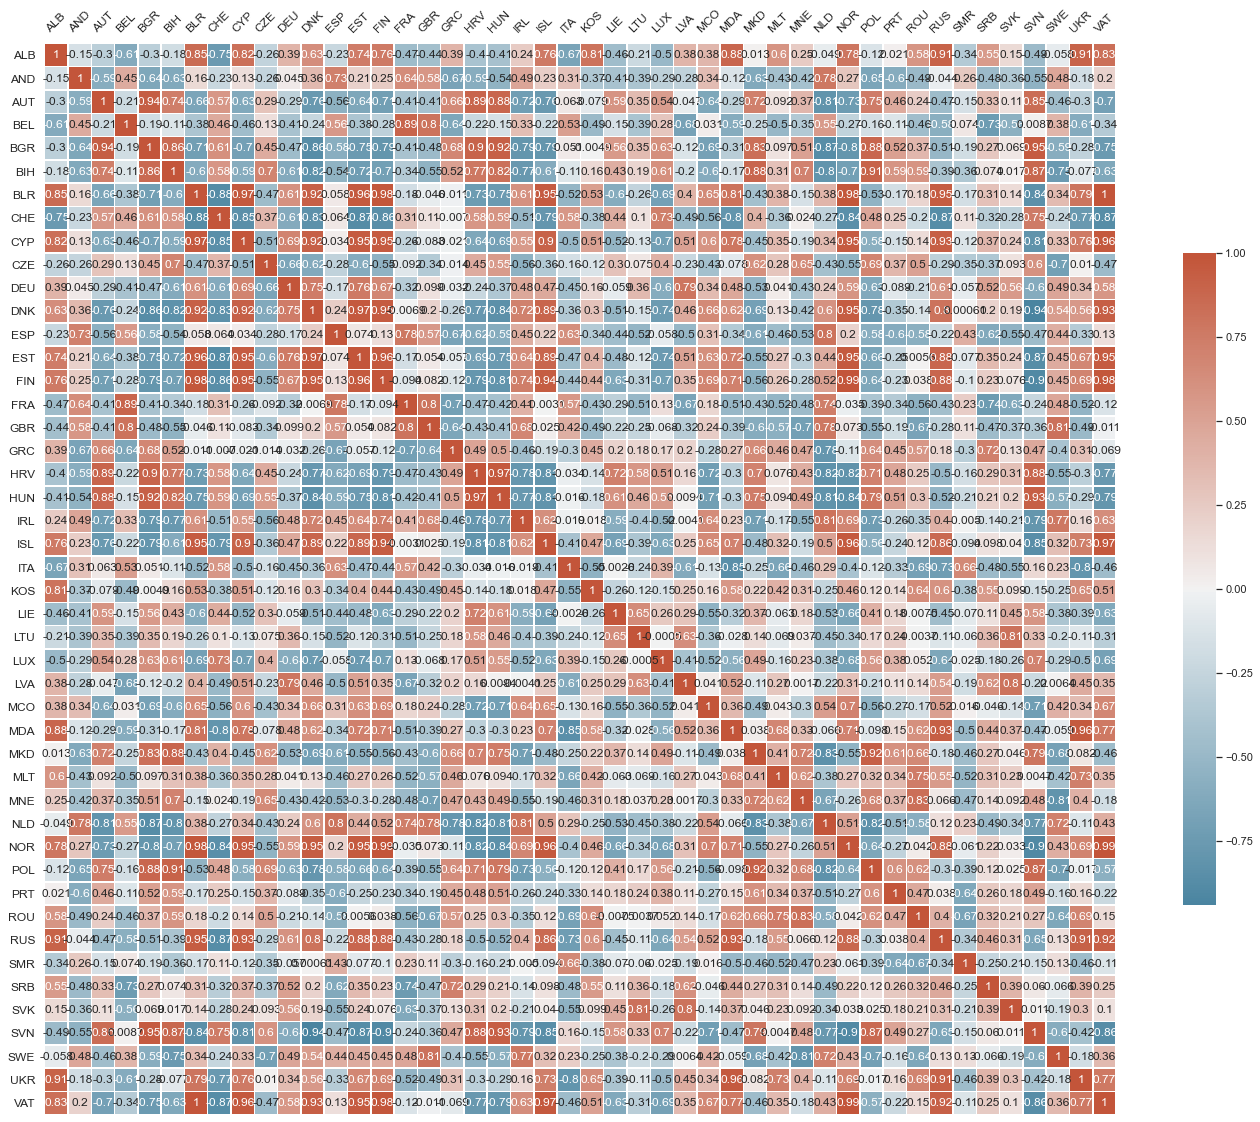

In [64]:
plt.figure(figsize=(24,24))
sns.set_theme(style='white')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
hm = sns.heatmap(deaths_corr_iso, square=True, cmap=cmap, center=0,
                annot=True, xticklabels=True, yticklabels=True, 
                cbar_kws={'shrink': 0.5}, cbar=True, linewidths=.5)
hm.set_xticklabels(hm.get_xticklabels(), rotation=45) 
hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
hm.set(xlabel=None, ylabel=None)
hm.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()

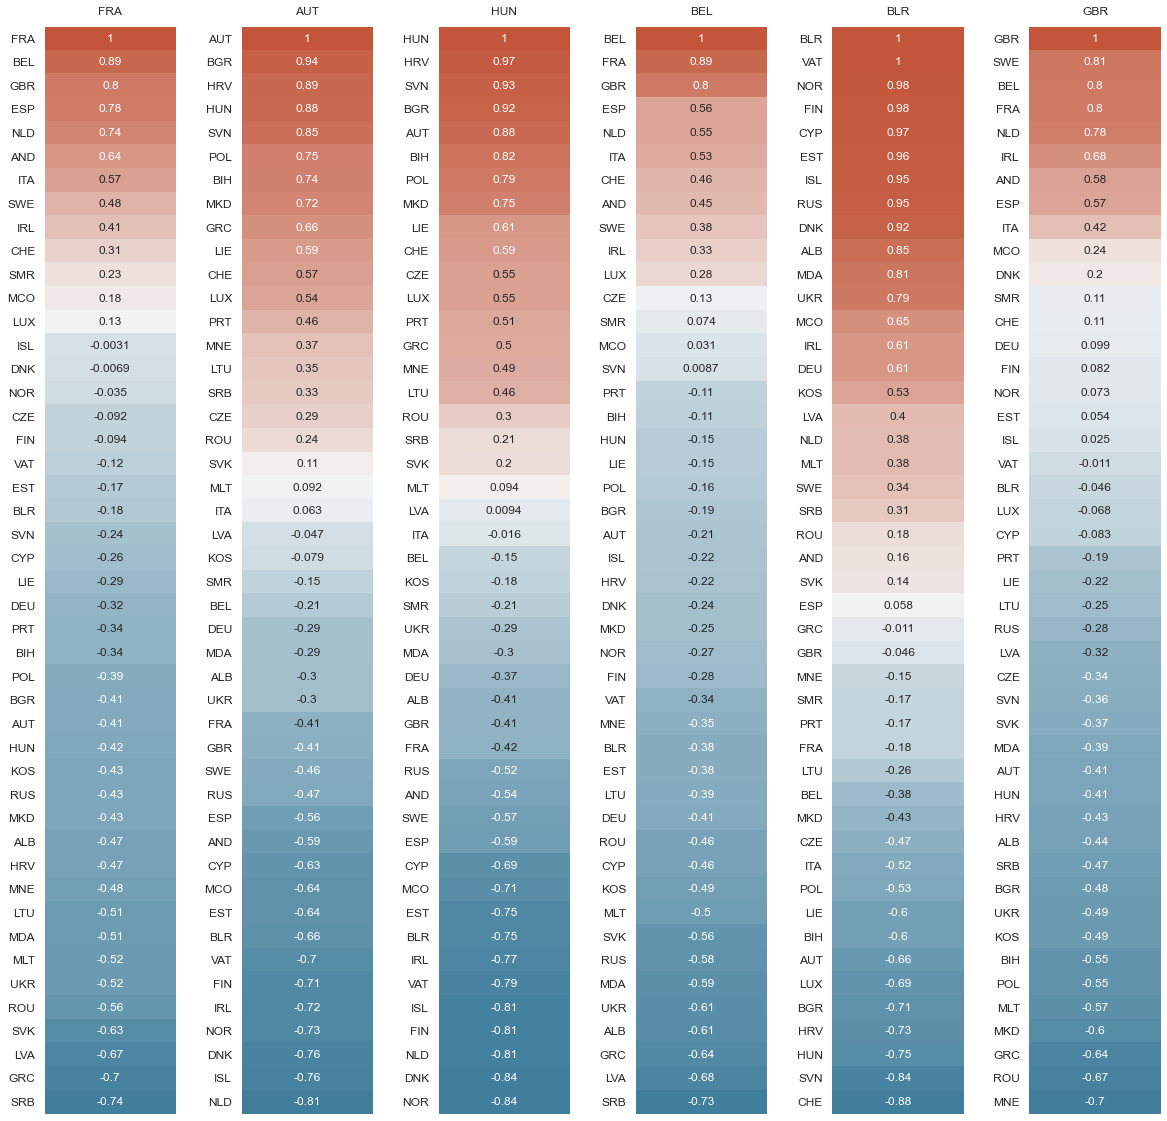

In [65]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.5)
g1=sns.heatmap(deaths_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g2=sns.heatmap(deaths_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g3=sns.heatmap(deaths_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g4=sns.heatmap(deaths_corr_iso[['BEL']].sort_values('BEL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g5=sns.heatmap(deaths_corr_iso[['BLR']].sort_values('BLR',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g6=sns.heatmap(deaths_corr_iso[['GBR']].sort_values('GBR',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)

g1.set(xlabel=None, ylabel=None)
g2.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

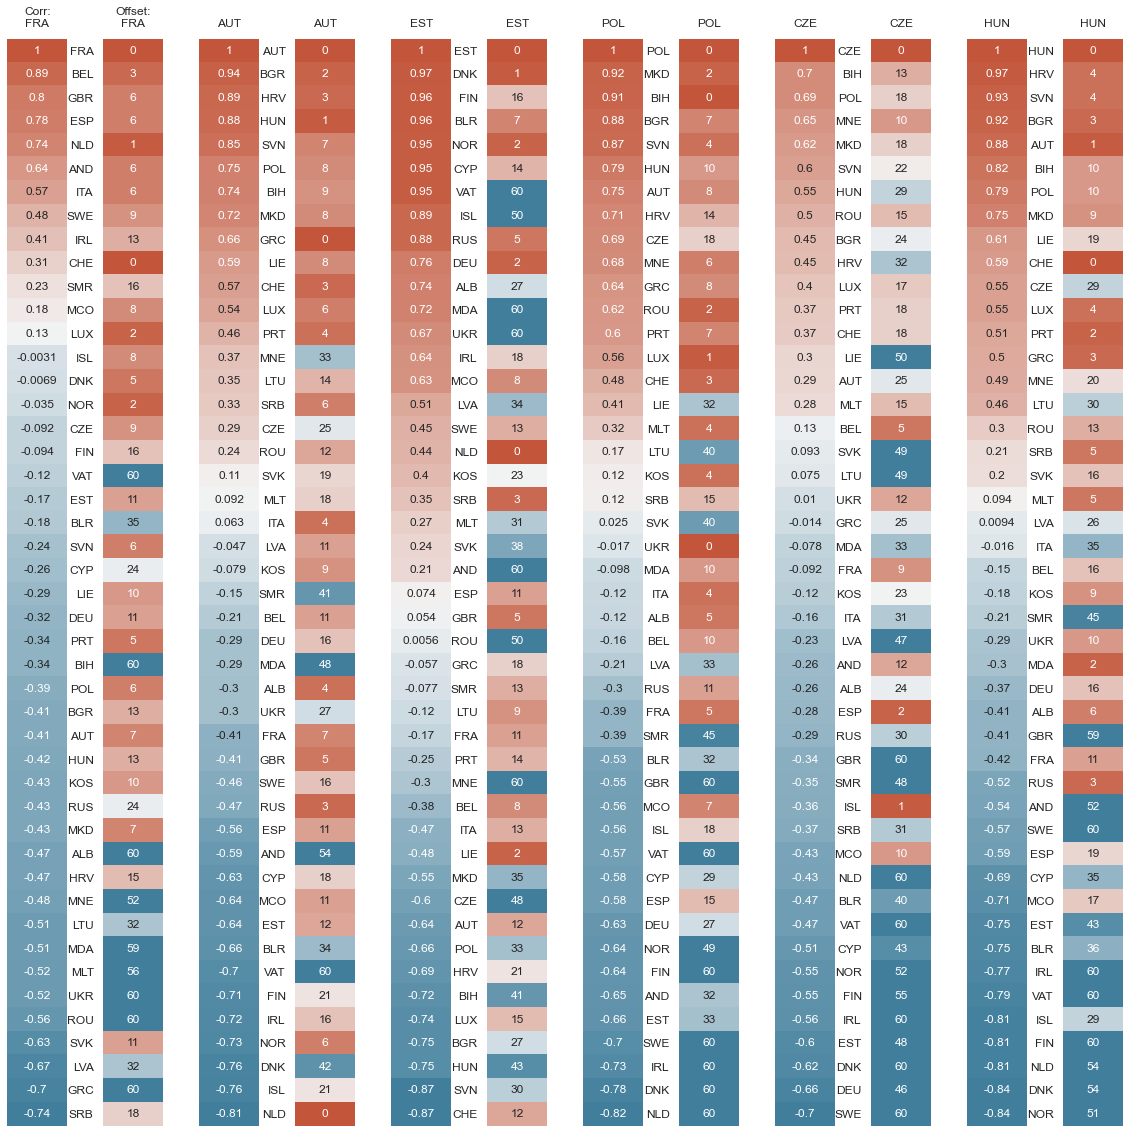

In [296]:
fig, (ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44, ax5, ax55, ax6, ax66) = plt.subplots(1,12, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.6)
cmap2=sns.diverging_palette(20, 230, as_cmap=True)
g1=sns.heatmap(deaths_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g11=sns.heatmap(abs(deaths_offsets_df_dict['FRA']), annot=True, cmap=cmap2, ax=ax11, vmax=46, vmin=0, center=None, cbar=False)
g2=sns.heatmap(deaths_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g22=sns.heatmap(abs(deaths_offsets_df_dict['AUT']), annot=True, cmap=cmap2, ax=ax22, vmax=46, vmin=0, center=None, cbar=False)
g3=sns.heatmap(deaths_corr_iso[['EST']].sort_values('EST',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g33=sns.heatmap(abs(deaths_offsets_df_dict['EST']), annot=True, cmap=cmap2, ax=ax33, vmax=46, vmin=0, center=None, cbar=False)
g4=sns.heatmap(deaths_corr_iso[['POL']].sort_values('POL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g44=sns.heatmap(abs(deaths_offsets_df_dict['POL']), annot=True, cmap=cmap2, ax=ax44, vmax=46, vmin=0, center=None, cbar=False)
g5=sns.heatmap(deaths_corr_iso[['CZE']].sort_values('CZE',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g55=sns.heatmap(abs(deaths_offsets_df_dict['CZE']), annot=True, cmap=cmap2, ax=ax55, vmax=46, vmin=0, center=None, cbar=False)
g6=sns.heatmap(deaths_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)
g66=sns.heatmap(abs(deaths_offsets_df_dict['HUN']), annot=True, cmap=cmap2, ax=ax66, vmax=46, vmin=0, center=None, cbar=False)

g1.set(xlabel='Corr:', ylabel=None)
g1.xaxis.set_label_position('top')
g11.set(xlabel='Offset:', ylabel=None)
g11.xaxis.set_label_position('top')
g2.set(xlabel=None, ylabel=None)
g22.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g33.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g44.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g55.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)
g66.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g11.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g22.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g33.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g44.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g55.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g66.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

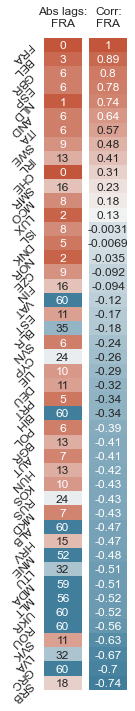

In [295]:
fig, (ax1, ax11) = plt.subplots(1,2, figsize=(1.5,12))
#fig.subplots_adjust(hspace=1)
#fig.subplots_adjust(wspace=1)

cmap2=sns.diverging_palette(20, 230, as_cmap=True)

g1=sns.heatmap(deaths_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax11, cmap=cmap, cbar=False)
g11=sns.heatmap(abs(deaths_offsets_df_dict['FRA']), annot=True, cmap=cmap2, ax=ax1, vmax=46, vmin=0, center=None, cbar=False)

g1.set_xlabel(xlabel='Corr:', rotation=0)
g1.set_ylabel(ylabel=None)
g1.xaxis.set_label_position('top')
g11.set_xlabel(xlabel='Abs lags:', rotation=0)
g11.set_ylabel(ylabel=None)
g11.xaxis.set_label_position('top')

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g11.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

g1.set_xticklabels(g1.get_xticklabels(), rotation=0)
g11.set_xticklabels(g11.get_xticklabels(), rotation=0)
g11.set_yticklabels(g11.get_yticklabels(), rotation=-45-90)

plt.show()
# paste this horizontally to Word

# get positive_rate results from function

In [67]:
pos_corr_iso, pos_corr_loc, pos_offsets_df_dict = get_results(data=data1_cases, variable='positive_rate')

  0%|          | 0/36 [00:00<?, ?it/s]

dataframe shape after demean: (347, 36)


100%|██████████| 36/36 [01:24<00:00,  2.35s/it]


## save as CSV files

In [68]:
pos_corr_loc.to_csv('positive_rate_demeaned_corr.csv')

## plot heatmap of demeaned corr matrix

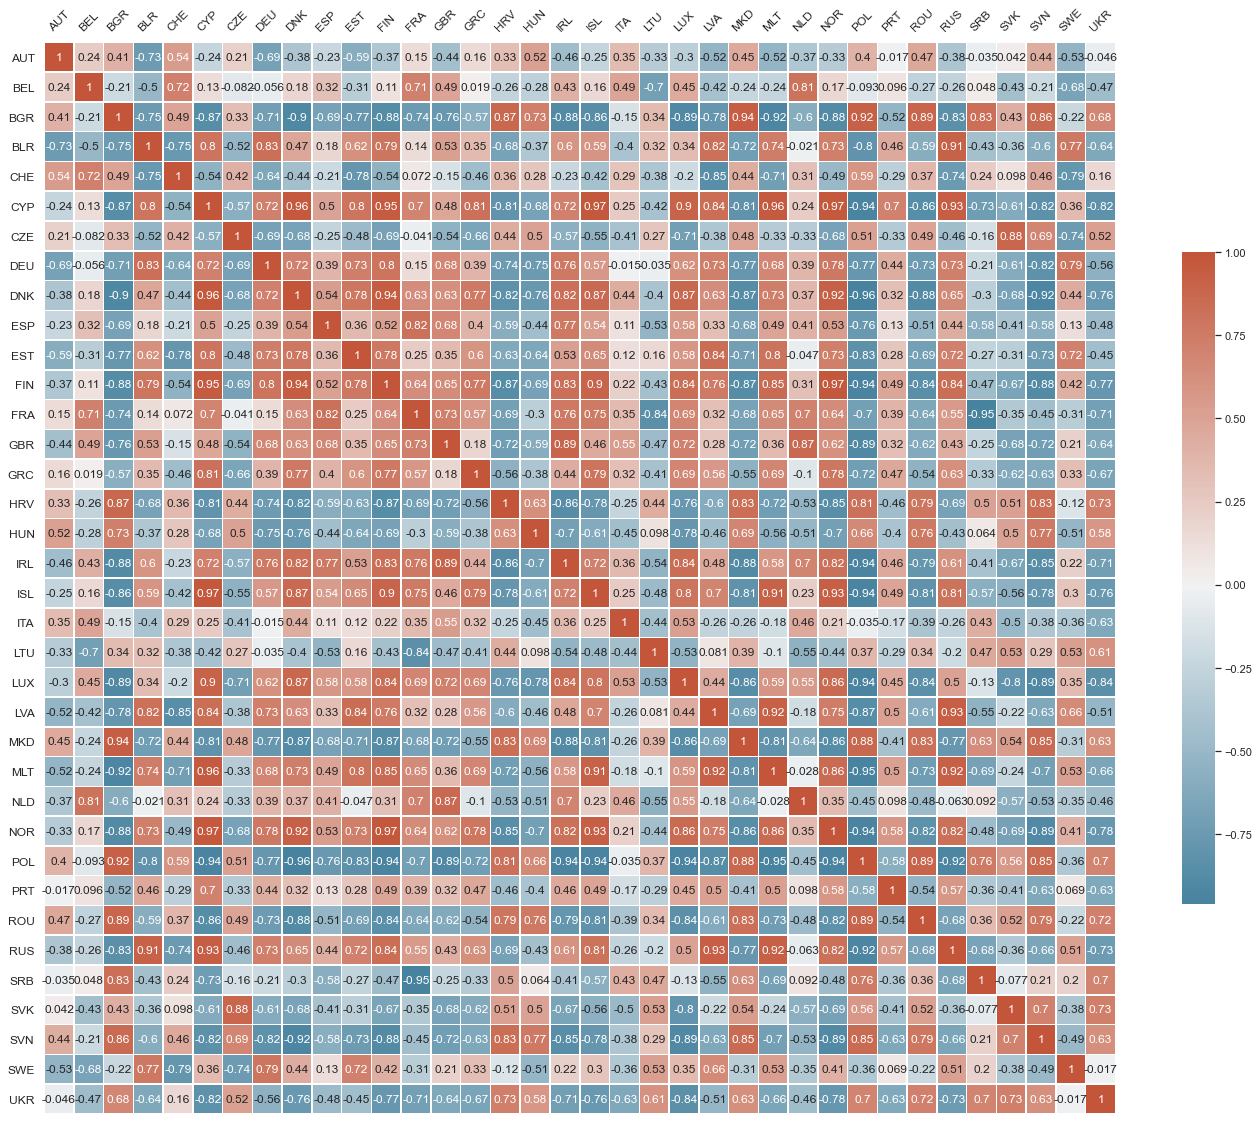

In [69]:
plt.figure(figsize=(24,24))
sns.set_theme(style='white')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
hm = sns.heatmap(pos_corr_iso, square=True, cmap=cmap, center=0,
                annot=True, xticklabels=True, yticklabels=True, 
                cbar_kws={'shrink': 0.5}, cbar=True, linewidths=.5)
hm.set_xticklabels(hm.get_xticklabels(), rotation=45) 
hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
hm.set(xlabel=None, ylabel=None)
hm.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()

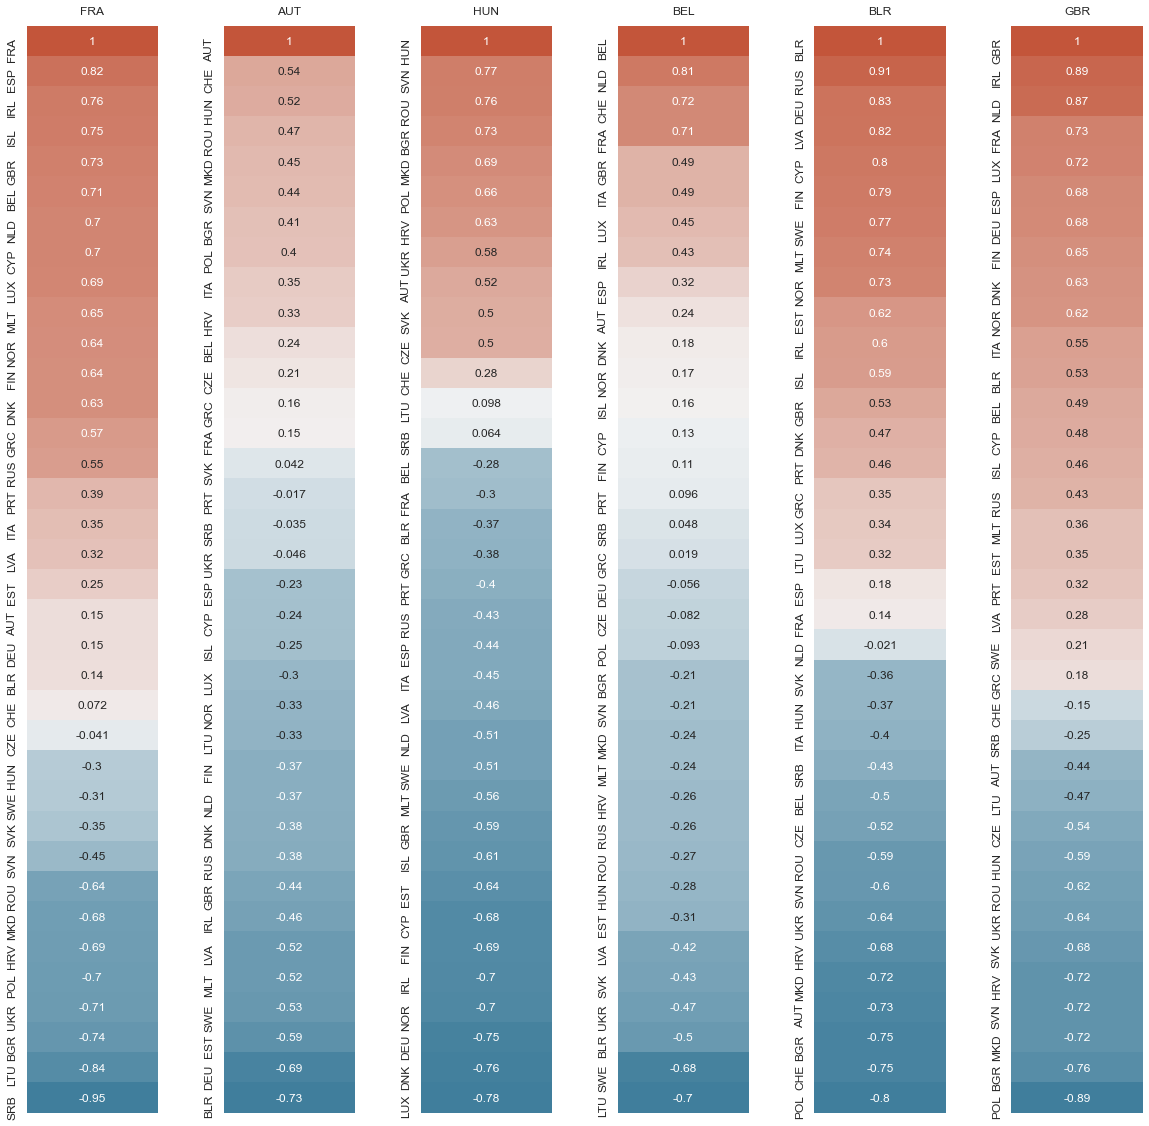

In [70]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.5)
g1=sns.heatmap(pos_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g2=sns.heatmap(pos_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g3=sns.heatmap(pos_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g4=sns.heatmap(pos_corr_iso[['BEL']].sort_values('BEL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g5=sns.heatmap(pos_corr_iso[['BLR']].sort_values('BLR',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g6=sns.heatmap(pos_corr_iso[['GBR']].sort_values('GBR',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)

g1.set(xlabel=None, ylabel=None)
g2.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

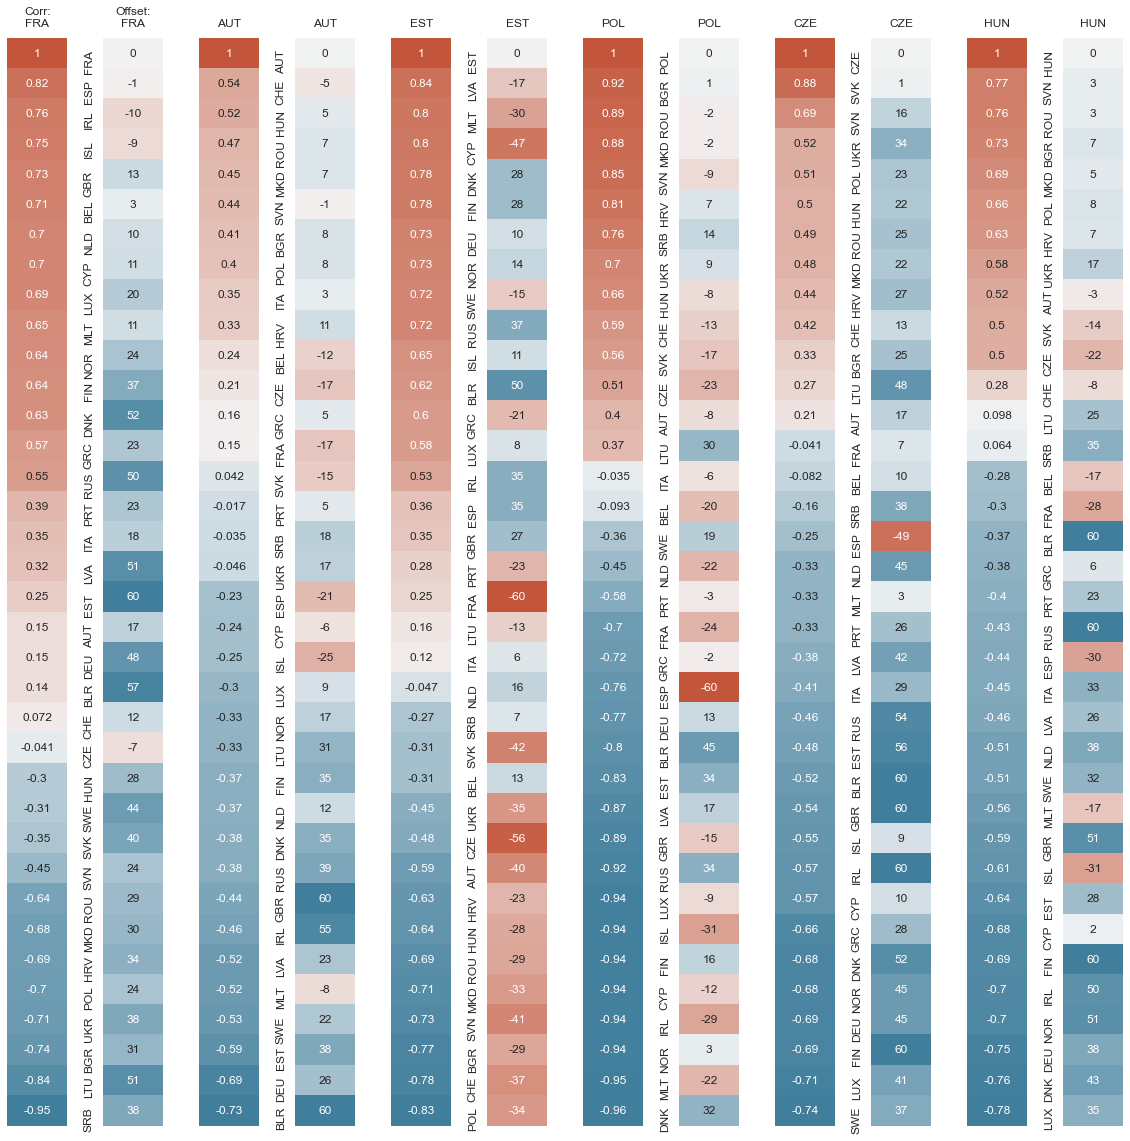

In [71]:
fig, (ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44, ax5, ax55, ax6, ax66) = plt.subplots(1,12, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.6)
cmap2=sns.diverging_palette(20, 230, as_cmap=True)
g1=sns.heatmap(pos_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g11=sns.heatmap(pos_offsets_df_dict['FRA'], annot=True, cmap=cmap2, ax=ax11, center=0, cbar=False)
g2=sns.heatmap(pos_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g22=sns.heatmap(pos_offsets_df_dict['AUT'], annot=True, cmap=cmap2, ax=ax22, center=0, cbar=False)
g3=sns.heatmap(pos_corr_iso[['EST']].sort_values('EST',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g33=sns.heatmap(pos_offsets_df_dict['EST'], annot=True, cmap=cmap2, ax=ax33, center=0, cbar=False)
g4=sns.heatmap(pos_corr_iso[['POL']].sort_values('POL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g44=sns.heatmap(pos_offsets_df_dict['POL'], annot=True, cmap=cmap2, ax=ax44, center=0, cbar=False)
g5=sns.heatmap(pos_corr_iso[['CZE']].sort_values('CZE',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g55=sns.heatmap(pos_offsets_df_dict['CZE'], annot=True, cmap=cmap2, ax=ax55, center=0, cbar=False)
g6=sns.heatmap(pos_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)
g66=sns.heatmap(pos_offsets_df_dict['HUN'], annot=True, cmap=cmap2, ax=ax66, center=0, cbar=False)

g1.set(xlabel='Corr:', ylabel=None)
g1.xaxis.set_label_position('top')
g11.set(xlabel='Offset:', ylabel=None)
g11.xaxis.set_label_position('top')
g2.set(xlabel=None, ylabel=None)
g22.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g33.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g44.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g55.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)
g66.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g11.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g22.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g33.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g44.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g55.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g66.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

# get new_tests_smoothed_per_thousand results from function

In [72]:
tests_corr_iso, tests_corr_loc, tests_offsets_df_dict = get_results(data=data1_cases, 
                                                                    variable='new_tests_smoothed_per_thousand')

  0%|          | 0/36 [00:00<?, ?it/s]

dataframe shape after demean: (347, 36)


100%|██████████| 36/36 [01:25<00:00,  2.39s/it]


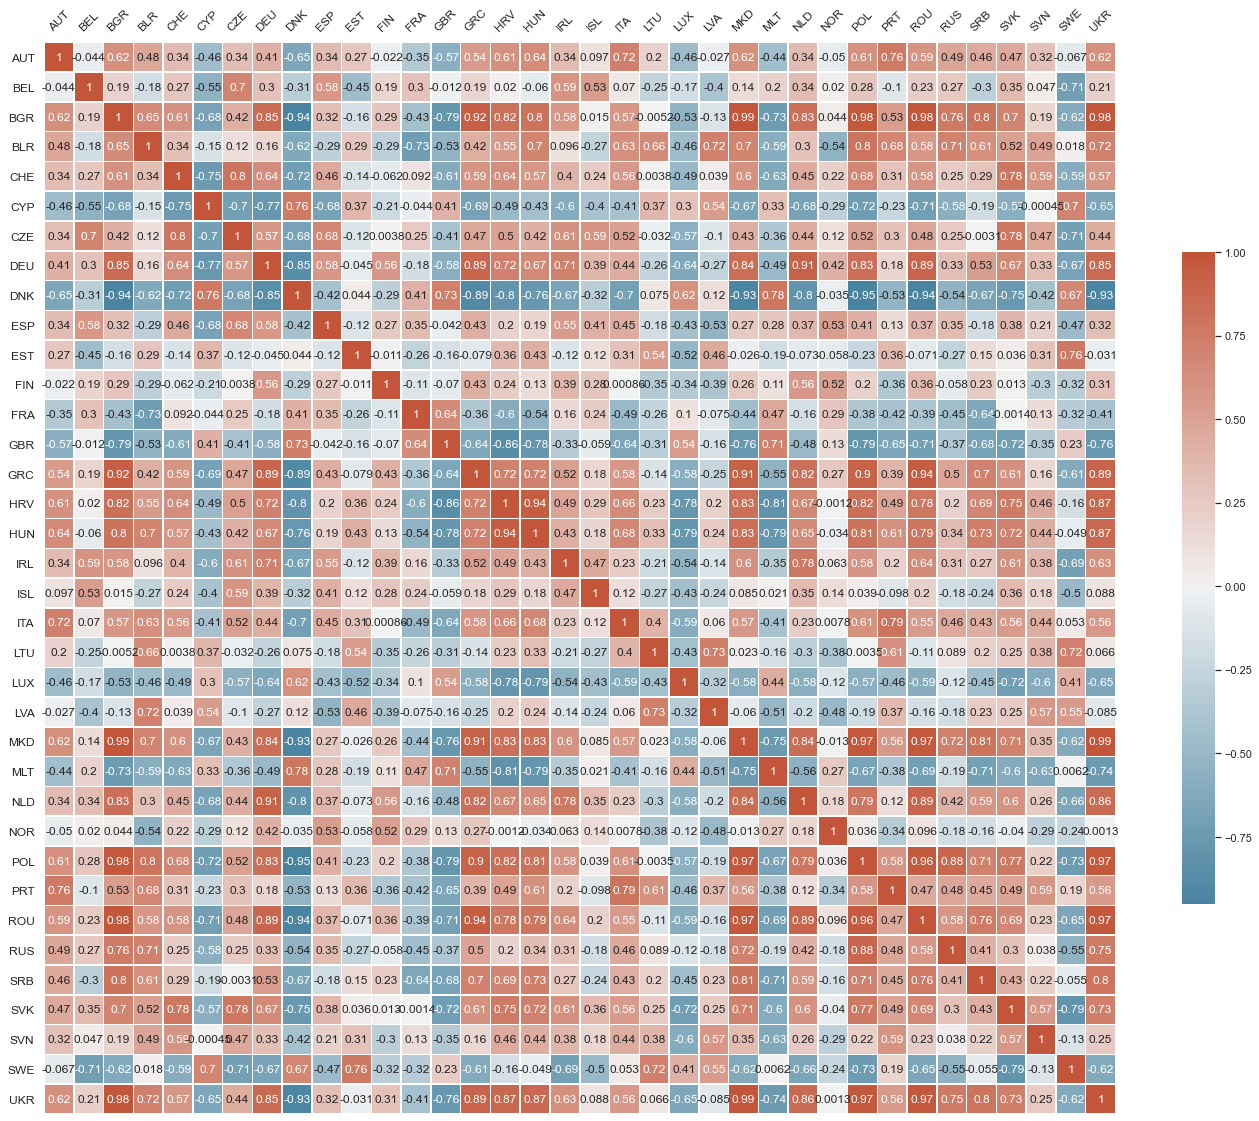

In [73]:
plt.figure(figsize=(24,24))
sns.set_theme(style='white')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
hm = sns.heatmap(tests_corr_iso, square=True, cmap=cmap, center=0,
                annot=True, xticklabels=True, yticklabels=True, 
                cbar_kws={'shrink': 0.5}, cbar=True, linewidths=.5)
hm.set_xticklabels(hm.get_xticklabels(), rotation=45) 
hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
hm.set(xlabel=None, ylabel=None)
hm.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()

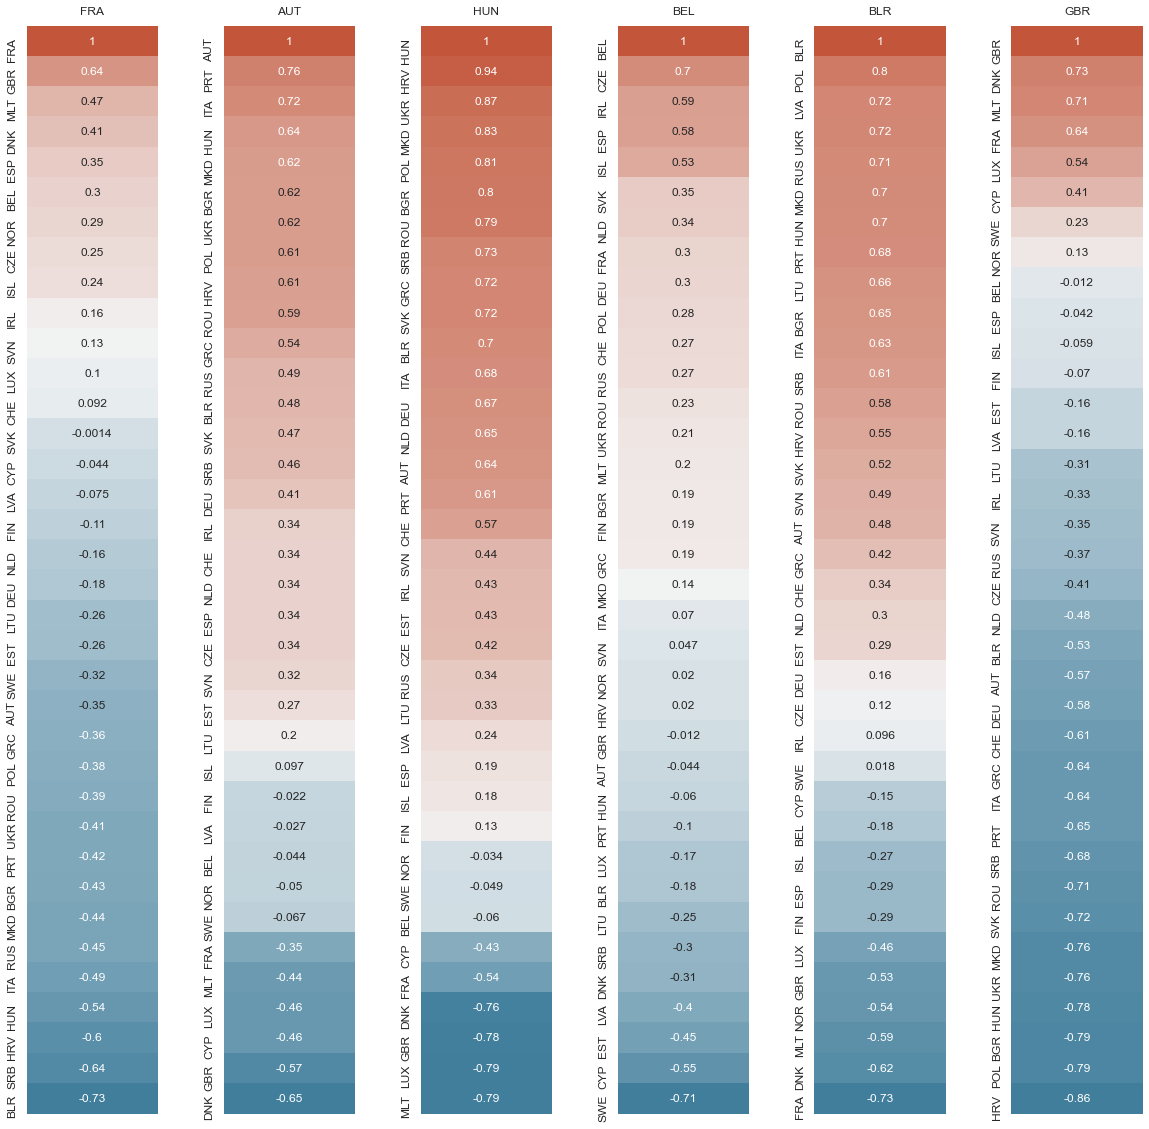

In [74]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.5)
g1=sns.heatmap(tests_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g2=sns.heatmap(tests_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g3=sns.heatmap(tests_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g4=sns.heatmap(tests_corr_iso[['BEL']].sort_values('BEL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g5=sns.heatmap(tests_corr_iso[['BLR']].sort_values('BLR',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g6=sns.heatmap(tests_corr_iso[['GBR']].sort_values('GBR',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)

g1.set(xlabel=None, ylabel=None)
g2.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

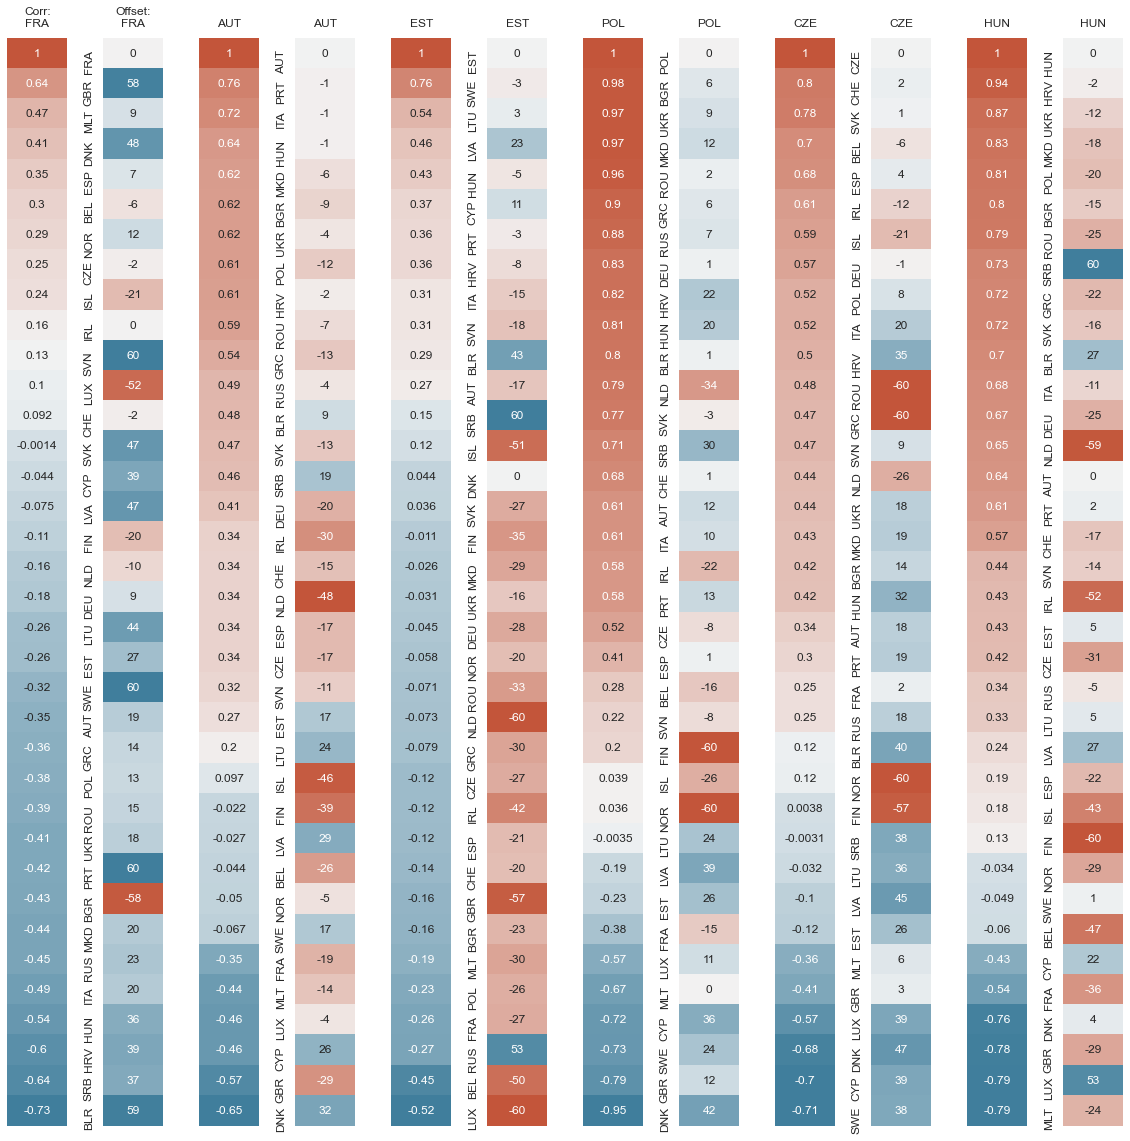

In [75]:
fig, (ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44, ax5, ax55, ax6, ax66) = plt.subplots(1,12, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.6)
cmap2=sns.diverging_palette(20, 230, as_cmap=True)
g1=sns.heatmap(tests_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g11=sns.heatmap(tests_offsets_df_dict['FRA'], annot=True, cmap=cmap2, ax=ax11, center=0, cbar=False)
g2=sns.heatmap(tests_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g22=sns.heatmap(tests_offsets_df_dict['AUT'], annot=True, cmap=cmap2, ax=ax22, center=0, cbar=False)
g3=sns.heatmap(tests_corr_iso[['EST']].sort_values('EST',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g33=sns.heatmap(tests_offsets_df_dict['EST'], annot=True, cmap=cmap2, ax=ax33, center=0, cbar=False)
g4=sns.heatmap(tests_corr_iso[['POL']].sort_values('POL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g44=sns.heatmap(tests_offsets_df_dict['POL'], annot=True, cmap=cmap2, ax=ax44, center=0, cbar=False)
g5=sns.heatmap(tests_corr_iso[['CZE']].sort_values('CZE',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g55=sns.heatmap(tests_offsets_df_dict['CZE'], annot=True, cmap=cmap2, ax=ax55, center=0, cbar=False)
g6=sns.heatmap(tests_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)
g66=sns.heatmap(tests_offsets_df_dict['HUN'], annot=True, cmap=cmap2, ax=ax66, center=0, cbar=False)

g1.set(xlabel='Corr:', ylabel=None)
g1.xaxis.set_label_position('top')
g11.set(xlabel='Offset:', ylabel=None)
g11.xaxis.set_label_position('top')
g2.set(xlabel=None, ylabel=None)
g22.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g33.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g44.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g55.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)
g66.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g11.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g22.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g33.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g44.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g55.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g66.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

# get reproduction_rate results from function

In [76]:
reprod_corr_iso, reprod_corr_loc, reprod_offsets_df_dict = get_results(data=data1_cases, 
                                                                    variable='reproduction_rate')

  0%|          | 0/45 [00:00<?, ?it/s]

dataframe shape after demean: (347, 45)


100%|██████████| 45/45 [02:14<00:00,  2.99s/it]


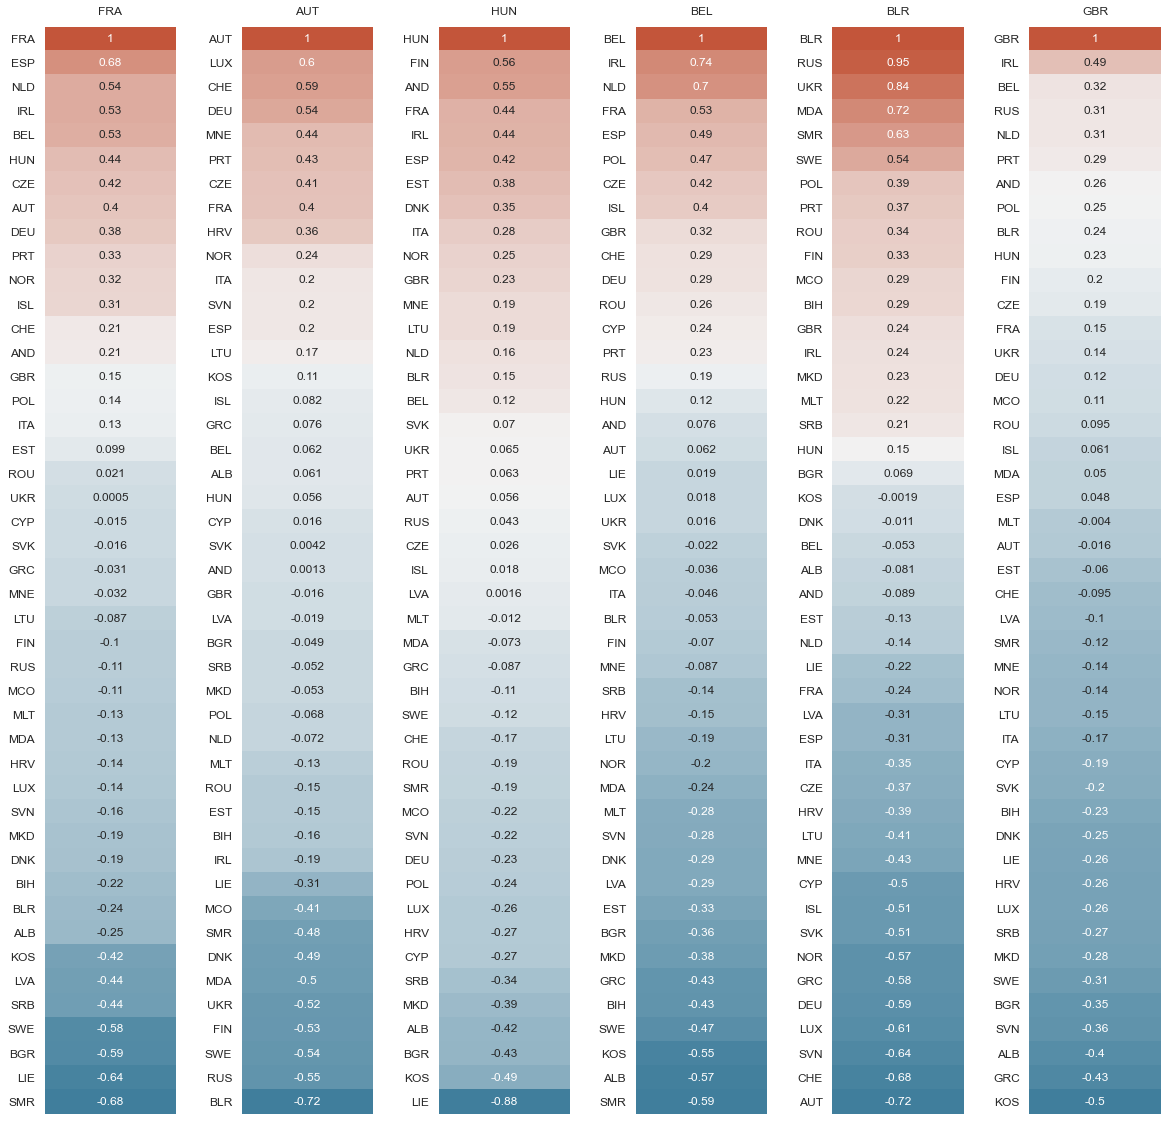

In [77]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.5)
g1=sns.heatmap(reprod_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g2=sns.heatmap(reprod_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g3=sns.heatmap(reprod_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g4=sns.heatmap(reprod_corr_iso[['BEL']].sort_values('BEL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g5=sns.heatmap(reprod_corr_iso[['BLR']].sort_values('BLR',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g6=sns.heatmap(reprod_corr_iso[['GBR']].sort_values('GBR',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)

g1.set(xlabel=None, ylabel=None)
g2.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

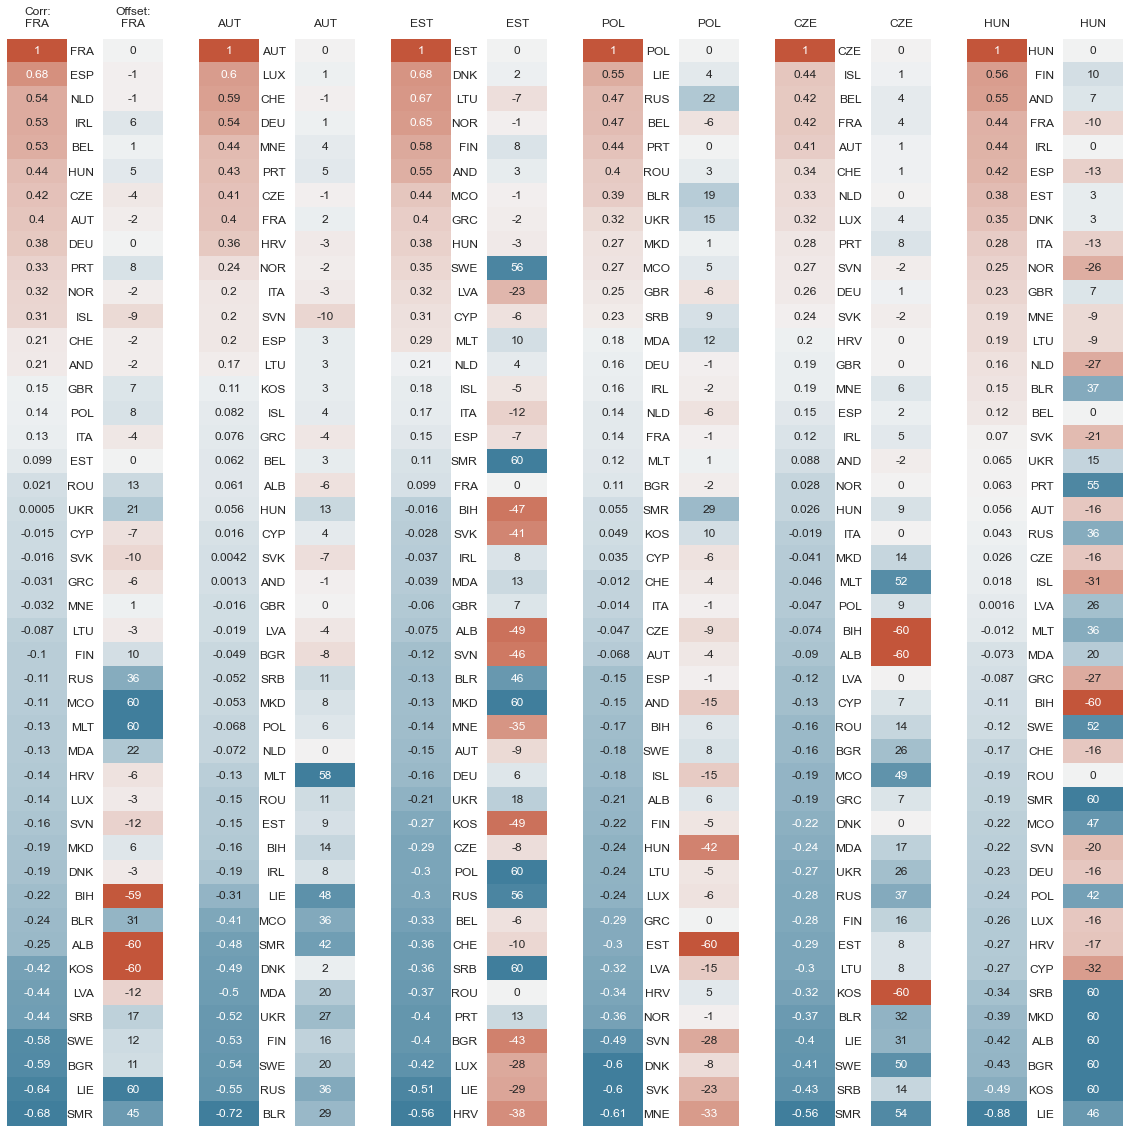

In [78]:
fig, (ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44, ax5, ax55, ax6, ax66) = plt.subplots(1,12, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.6)
cmap2=sns.diverging_palette(20, 230, as_cmap=True)
g1=sns.heatmap(reprod_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g11=sns.heatmap(reprod_offsets_df_dict['FRA'], annot=True, cmap=cmap2, ax=ax11, center=0, cbar=False)
g2=sns.heatmap(reprod_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g22=sns.heatmap(reprod_offsets_df_dict['AUT'], annot=True, cmap=cmap2, ax=ax22, center=0, cbar=False)
g3=sns.heatmap(reprod_corr_iso[['EST']].sort_values('EST',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g33=sns.heatmap(reprod_offsets_df_dict['EST'], annot=True, cmap=cmap2, ax=ax33, center=0, cbar=False)
g4=sns.heatmap(reprod_corr_iso[['POL']].sort_values('POL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g44=sns.heatmap(reprod_offsets_df_dict['POL'], annot=True, cmap=cmap2, ax=ax44, center=0, cbar=False)
g5=sns.heatmap(reprod_corr_iso[['CZE']].sort_values('CZE',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g55=sns.heatmap(reprod_offsets_df_dict['CZE'], annot=True, cmap=cmap2, ax=ax55, center=0, cbar=False)
g6=sns.heatmap(reprod_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)
g66=sns.heatmap(reprod_offsets_df_dict['HUN'], annot=True, cmap=cmap2, ax=ax66, center=0, cbar=False)

g1.set(xlabel='Corr:', ylabel=None)
g1.xaxis.set_label_position('top')
g11.set(xlabel='Offset:', ylabel=None)
g11.xaxis.set_label_position('top')
g2.set(xlabel=None, ylabel=None)
g22.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g33.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g44.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g55.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)
g66.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g11.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g22.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g33.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g44.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g55.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g66.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

# get hosp_patients_per_million results from function

In [79]:
hosp_corr_iso, hosp_corr_loc, hosp_offsets_df_dict = get_results(data=data1_cases, 
                                                                    variable='hosp_patients_per_million')

  0%|          | 0/25 [00:00<?, ?it/s]

dataframe shape after demean: (347, 25)


100%|██████████| 25/25 [00:40<00:00,  1.64s/it]


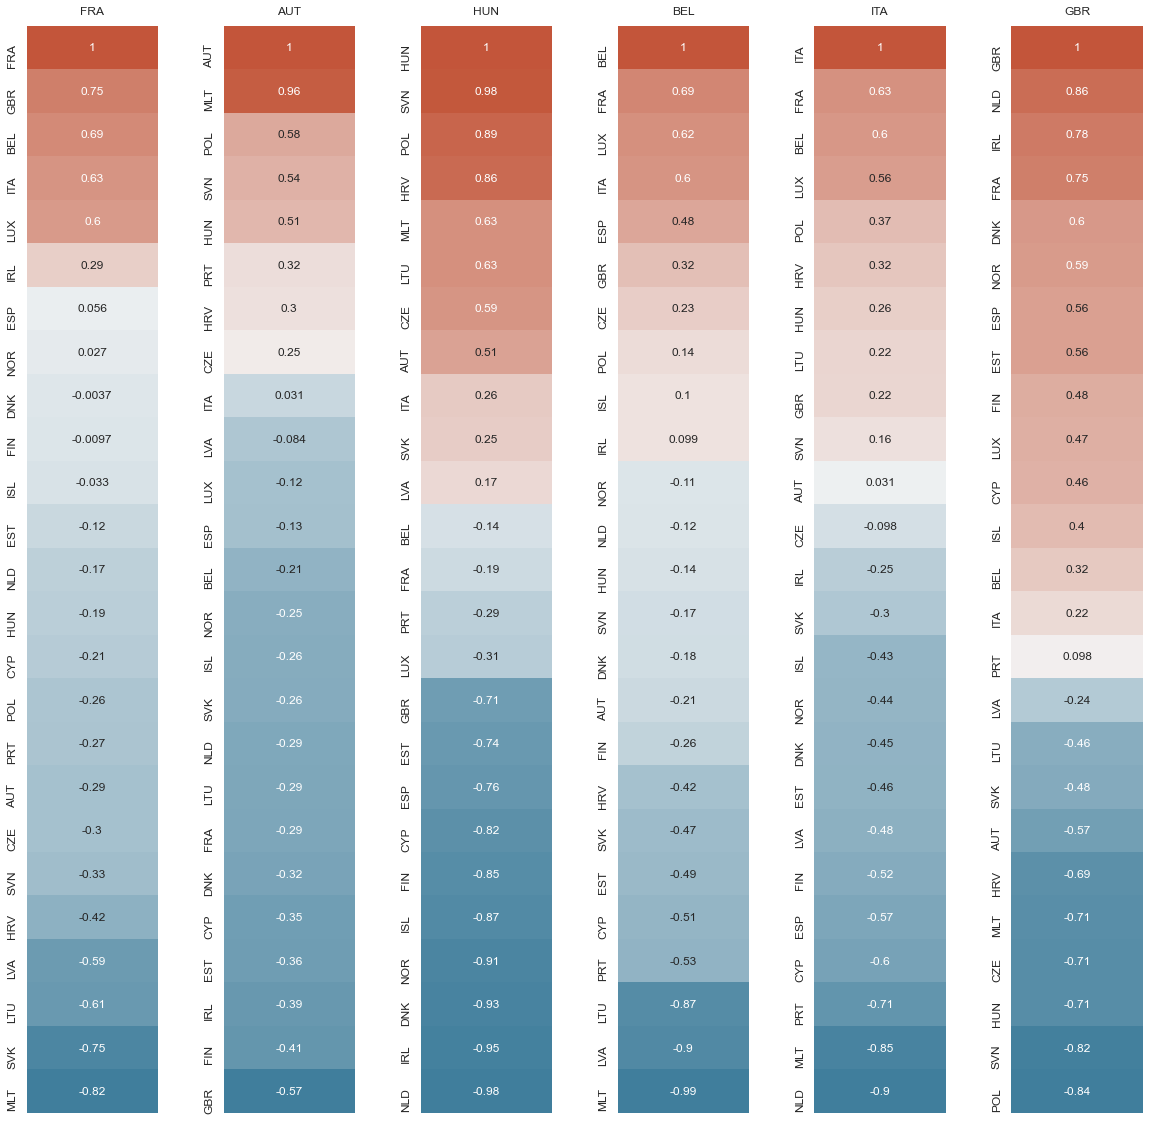

In [81]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.5)
g1=sns.heatmap(hosp_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g2=sns.heatmap(hosp_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g3=sns.heatmap(hosp_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g4=sns.heatmap(hosp_corr_iso[['BEL']].sort_values('BEL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g5=sns.heatmap(hosp_corr_iso[['ITA']].sort_values('ITA',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g6=sns.heatmap(hosp_corr_iso[['GBR']].sort_values('GBR',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)

g1.set(xlabel=None, ylabel=None)
g2.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

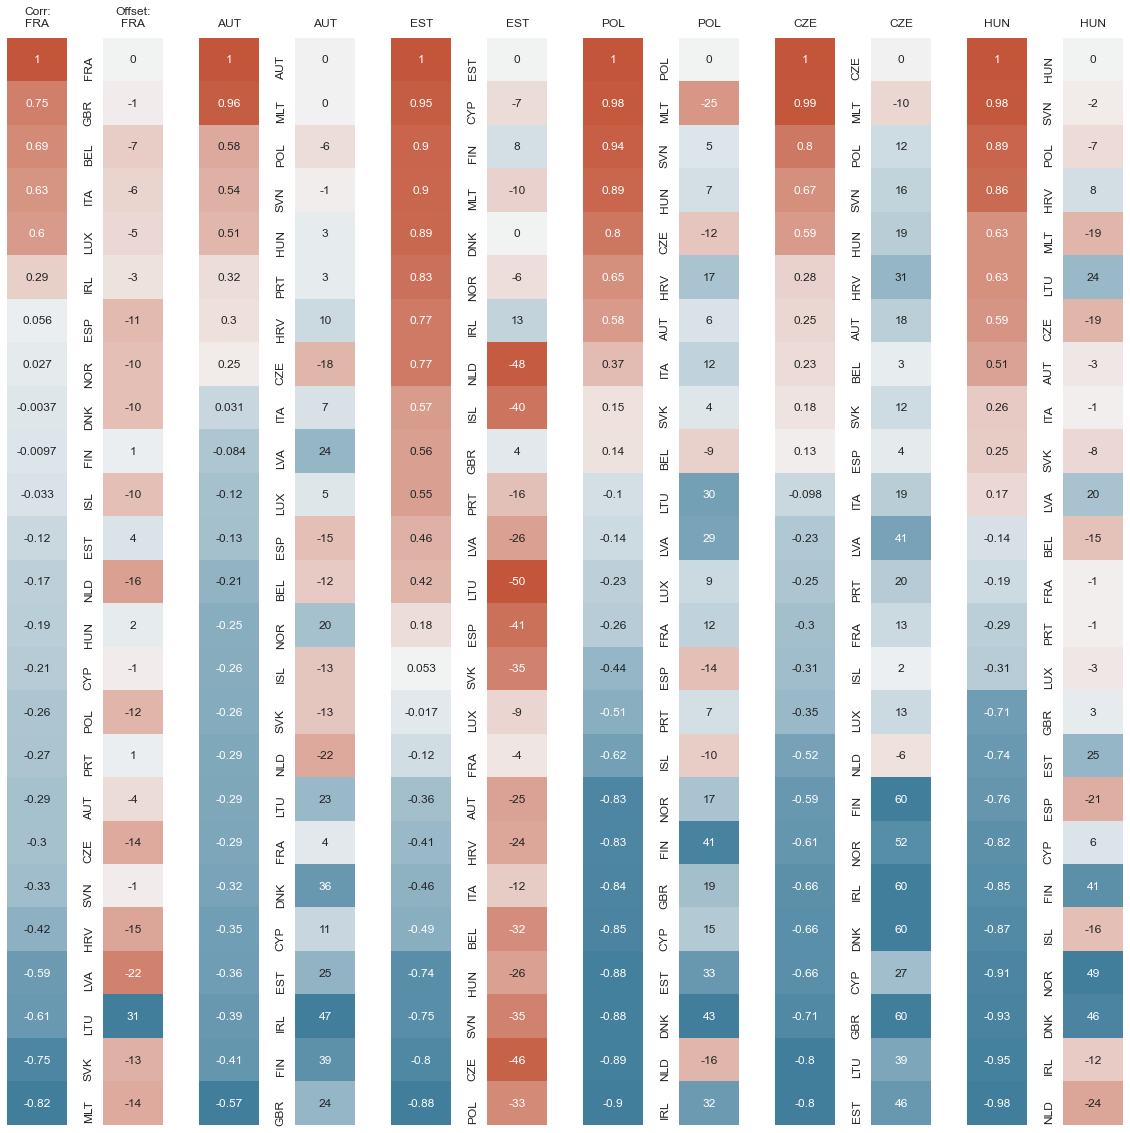

In [82]:
fig, (ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44, ax5, ax55, ax6, ax66) = plt.subplots(1,12, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.6)
cmap2=sns.diverging_palette(20, 230, as_cmap=True)
g1=sns.heatmap(hosp_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g11=sns.heatmap(hosp_offsets_df_dict['FRA'], annot=True, cmap=cmap2, ax=ax11, center=0, cbar=False)
g2=sns.heatmap(hosp_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g22=sns.heatmap(hosp_offsets_df_dict['AUT'], annot=True, cmap=cmap2, ax=ax22, center=0, cbar=False)
g3=sns.heatmap(hosp_corr_iso[['EST']].sort_values('EST',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g33=sns.heatmap(hosp_offsets_df_dict['EST'], annot=True, cmap=cmap2, ax=ax33, center=0, cbar=False)
g4=sns.heatmap(hosp_corr_iso[['POL']].sort_values('POL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g44=sns.heatmap(hosp_offsets_df_dict['POL'], annot=True, cmap=cmap2, ax=ax44, center=0, cbar=False)
g5=sns.heatmap(hosp_corr_iso[['CZE']].sort_values('CZE',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g55=sns.heatmap(hosp_offsets_df_dict['CZE'], annot=True, cmap=cmap2, ax=ax55, center=0, cbar=False)
g6=sns.heatmap(hosp_corr_iso[['HUN']].sort_values('HUN',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)
g66=sns.heatmap(hosp_offsets_df_dict['HUN'], annot=True, cmap=cmap2, ax=ax66, center=0, cbar=False)

g1.set(xlabel='Corr:', ylabel=None)
g1.xaxis.set_label_position('top')
g11.set(xlabel='Offset:', ylabel=None)
g11.xaxis.set_label_position('top')
g2.set(xlabel=None, ylabel=None)
g22.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g33.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g44.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g55.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)
g66.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g11.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g22.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g33.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g44.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g55.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g66.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

# get icu_patients_per_million results from function 

In [83]:
icu_corr_iso, icu_corr_loc, icu_offsets_df_dict = get_results(data=data1_cases, 
                                                                    variable='icu_patients_per_million')

  0%|          | 0/21 [00:00<?, ?it/s]

dataframe shape after demean: (347, 21)


100%|██████████| 21/21 [00:28<00:00,  1.38s/it]


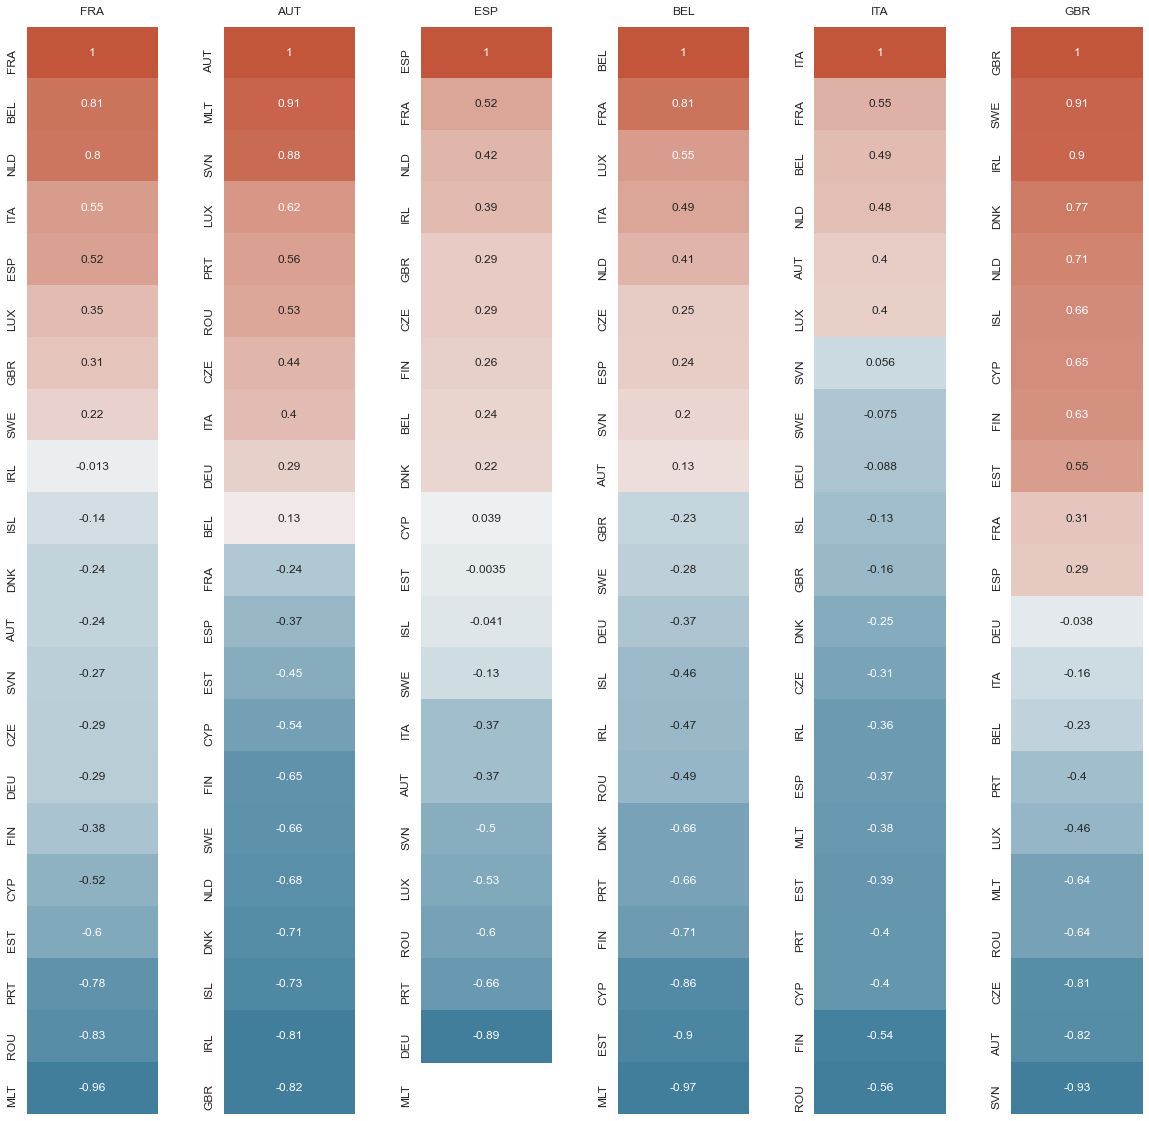

In [86]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.5)
g1=sns.heatmap(icu_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g2=sns.heatmap(icu_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g3=sns.heatmap(icu_corr_iso[['ESP']].sort_values('ESP',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g4=sns.heatmap(icu_corr_iso[['BEL']].sort_values('BEL',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g5=sns.heatmap(icu_corr_iso[['ITA']].sort_values('ITA',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g6=sns.heatmap(icu_corr_iso[['GBR']].sort_values('GBR',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)

g1.set(xlabel=None, ylabel=None)
g2.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

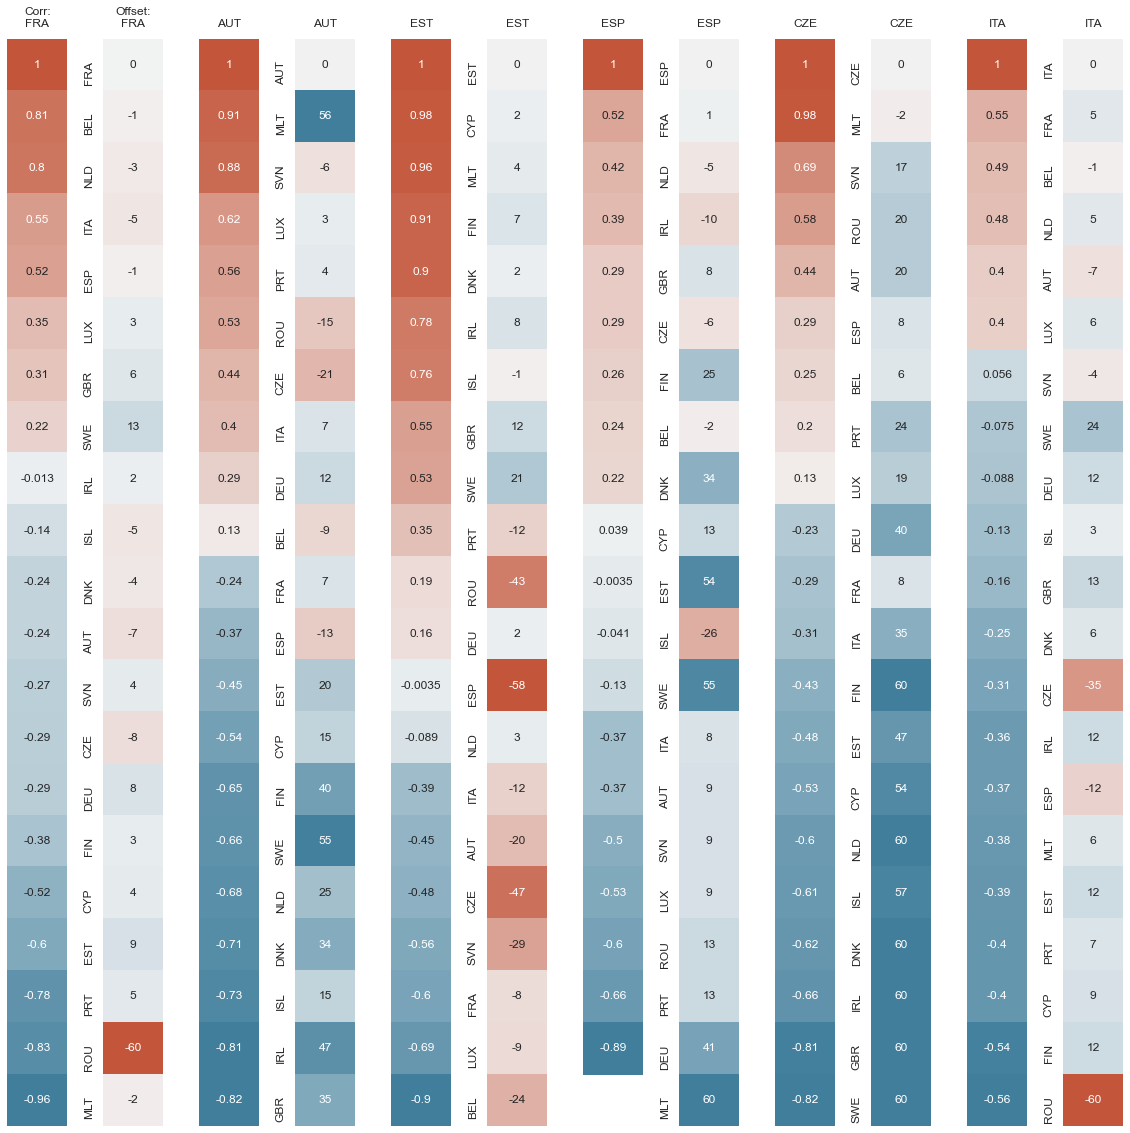

In [89]:
fig, (ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44, ax5, ax55, ax6, ax66) = plt.subplots(1,12, figsize=(20,20))
#fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.6)
cmap2=sns.diverging_palette(20, 230, as_cmap=True)
g1=sns.heatmap(icu_corr_iso[['FRA']].sort_values('FRA',ascending=False), annot=True, ax=ax1, cmap=cmap, cbar=False)
g11=sns.heatmap(icu_offsets_df_dict['FRA'], annot=True, cmap=cmap2, ax=ax11, center=0, cbar=False)
g2=sns.heatmap(icu_corr_iso[['AUT']].sort_values('AUT',ascending=False), annot=True, ax=ax2, cmap=cmap, cbar=False)
g22=sns.heatmap(icu_offsets_df_dict['AUT'], annot=True, cmap=cmap2, ax=ax22, center=0, cbar=False)
g3=sns.heatmap(icu_corr_iso[['EST']].sort_values('EST',ascending=False), annot=True, ax=ax3, cmap=cmap, cbar=False)
g33=sns.heatmap(icu_offsets_df_dict['EST'], annot=True, cmap=cmap2, ax=ax33, center=0, cbar=False)
g4=sns.heatmap(icu_corr_iso[['ESP']].sort_values('ESP',ascending=False), annot=True, ax=ax4, cmap=cmap, cbar=False)
g44=sns.heatmap(icu_offsets_df_dict['ESP'], annot=True, cmap=cmap2, ax=ax44, center=0, cbar=False)
g5=sns.heatmap(icu_corr_iso[['CZE']].sort_values('CZE',ascending=False), annot=True, ax=ax5, cmap=cmap, cbar=False)
g55=sns.heatmap(icu_offsets_df_dict['CZE'], annot=True, cmap=cmap2, ax=ax55, center=0, cbar=False)
g6=sns.heatmap(icu_corr_iso[['ITA']].sort_values('ITA',ascending=False), annot=True, ax=ax6, cmap=cmap, cbar=False)
g66=sns.heatmap(icu_offsets_df_dict['ITA'], annot=True, cmap=cmap2, ax=ax66, center=0, cbar=False)

g1.set(xlabel='Corr:', ylabel=None)
g1.xaxis.set_label_position('top')
g11.set(xlabel='Offset:', ylabel=None)
g11.xaxis.set_label_position('top')
g2.set(xlabel=None, ylabel=None)
g22.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)
g33.set(xlabel=None, ylabel=None)
g4.set(xlabel=None, ylabel=None)
g44.set(xlabel=None, ylabel=None)
g5.set(xlabel=None, ylabel=None)
g55.set(xlabel=None, ylabel=None)
g6.set(xlabel=None, ylabel=None)
g66.set(xlabel=None, ylabel=None)

g1.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g11.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g2.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g22.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g3.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g33.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g4.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g44.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g5.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g55.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
g6.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True, labelleft=False)
g66.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

<AxesSubplot:xlabel='date'>

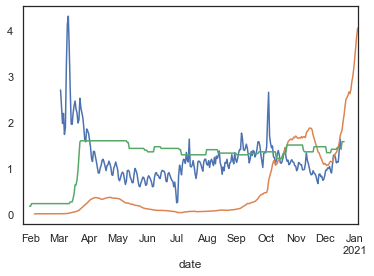

In [112]:
data1_cases['reproduction_rate']['GBR'].plot()
(data1_cases['new_cases_smoothed_per_million']['GBR']/200).plot()
(data1_cases['stringency_index']['GBR']/50).plot()

In [116]:
#!pip install tslearn

In [210]:
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=100)
model.fit(data1_cases['new_cases_smoothed_per_million'].dropna().T)

TimeSeriesKMeans(max_iter=100, metric='dtw', n_clusters=2)

In [211]:
model.fit_predict(data1_cases['new_cases_smoothed_per_million'].dropna().T)

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0])

In [212]:
model.predict(data1_cases['new_cases_smoothed_per_million'].dropna().T)

/Users/shinggg/anaconda3/lib/python3.6/site-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 46 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0])

In [213]:
dict(zip(data1_cases['new_cases_smoothed_per_million'].dropna().columns,model.fit_predict(data1_cases['new_cases_smoothed_per_million'].dropna().T)))

{'ALB': 1,
 'AND': 0,
 'AUT': 0,
 'BEL': 0,
 'BGR': 1,
 'BIH': 1,
 'BLR': 1,
 'CHE': 0,
 'CYP': 0,
 'CZE': 0,
 'DEU': 1,
 'DNK': 0,
 'ESP': 1,
 'EST': 1,
 'FIN': 1,
 'FRA': 1,
 'GBR': 0,
 'GRC': 1,
 'HRV': 0,
 'HUN': 1,
 'IRL': 1,
 'ISL': 1,
 'ITA': 1,
 'KOS': 1,
 'LIE': 0,
 'LTU': 0,
 'LUX': 0,
 'LVA': 1,
 'MCO': 1,
 'MDA': 1,
 'MKD': 1,
 'MLT': 1,
 'MNE': 0,
 'NLD': 0,
 'NOR': 1,
 'POL': 0,
 'PRT': 0,
 'ROU': 1,
 'RUS': 1,
 'SMR': 0,
 'SRB': 0,
 'SVK': 1,
 'SVN': 0,
 'SWE': 0,
 'UKR': 1,
 'VAT': 1}